**Summary**

    Helper Functions
    0.0 Data Preparation
        0.1 Data scaling
        0.2 Feature Encoding
    1.0 Feature Selection
        1.1 Training Test Split
            1.1.1. Testing Some Models
        1.2 Feature Selector (Random Forest)
    2.0 Machine Learning Modelling
        2.1 Manual Feature Selection
        2.2 Boruta Feature Selection
    3.0 Hyperparameter Fine Tuning
        3.1 Random Forest
        3.2 Logistic Regression
        3.3 Gradient Boosting
    4.0 Final Comparisons
        4.1 Dealing with Imbalance in Data
            Boruta Features
            All Features
    5.0 Business Impact
    Notes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from collections import Counter
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from boruta import BorutaPy

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from IPython.display import Audio 
from IPython.display import display as sound_alert

from joblib import dump, load

## Helper Functions

In [10]:
def train_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    return y_pred

def allDone():
  sound_alert(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

def cross_validation(model, X, y, cv=5, evaluation='accuracy'):
    cross_validation = cross_val_score(model, X, y, cv=cv, scoring=evaluation)
    evaluation_result = cross_validation.mean().round(2)
    std = cross_validation.std().round(2)
    print(f"Average {evaluation}: {evaluation_result} +- {std}")

In [2]:
raw_data = pd.read_pickle("data/data_to_ml.pkl")
raw_data.sample()

,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,...,age,spent_percentage_wines,spent_percentage_fruits,spent_percentage_meat,spent_percentage_fish,spent_percentage_sweet,spent_percentage_gold,percentage_web_purchases,percentage_catalog_purchases,percentage_store_purchases
300,1958,Graduation,Divorced,35246.0,1,1,2014-04-16,53,36,0,...,56,0.692308,0.0,0.230769,0.038462,0.038462,0.192308,0.428571,0.142857,0.428571


## 0.0 Data Preparation

In [12]:
data = raw_data.copy()

### 0.1 Data scaling

In [13]:
columns = data.select_dtypes(include=['int64', 'float64']).columns

In [14]:
min_max_scaler = MinMaxScaler() # range(0, 1)

for column in columns:
    if column != 'response':
        data[column] = min_max_scaler.fit_transform(data[[column]].values) 

### 0.2 Feature Encoding

In [15]:
codes = {'Basic':0, '2n Cycle':1, 'Graduation':2, 'Master':3, 'PhD':4}
data['education'] = data['education'].map( codes )

data = pd.get_dummies( data, prefix=['marital_status'], columns=['marital_status'] )

## 1.0 Feature Selection

In [16]:
df = data.copy()

### 1.1 Training Test Split

    "accepted_cmp"s
    Next campaign will be done with customers who has never participated in those test campaigns.   
    
    "dt_customer"
    It's not a time series problem. Though I could encode it
   

In [17]:
X = df.drop(columns=['response', 'dt_customer', 'num_accepted_cmps', 'accepted_cmp1', 'accepted_cmp2', 'accepted_cmp3', 
                     'accepted_cmp4', 'accepted_cmp5'])
y = df['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 1.1.1. Testing Some Models

                                    Average precision
        
        LogisticRegression           0.61 +- 0.11
        GradientBoostingClassifier   0.55 +- 0.05
        RandomForestClassifier       0.60 +- 0.14
        
[Precision VS Recall (by Google)](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

In [18]:
logistic = LogisticRegression(max_iter=500)

predictions = train_test_model(logistic, X_train, X_test, y_train, y_test)
cross_validation(logistic, X, y, cv=10, evaluation='precision') # Recall .32

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       518
           1       0.71      0.32      0.44        99

    accuracy                           0.87       617
   macro avg       0.80      0.65      0.69       617
weighted avg       0.86      0.87      0.85       617

Average precision: 0.61 +- 0.11


In [19]:
gradient_boosting = GradientBoostingClassifier(random_state=42)

predictions = train_test_model(gradient_boosting, X_train, X_test, y_train, y_test)
cross_validation(gradient_boosting, X, y, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       518
           1       0.65      0.31      0.42        99

    accuracy                           0.86       617
   macro avg       0.76      0.64      0.67       617
weighted avg       0.84      0.86      0.84       617

Average precision: 0.55 +- 0.05


### 1.2 Feature Selector (Random Forest)

In [20]:
random_forest = RandomForestClassifier(random_state=42)

predictions = train_test_model(random_forest, X_train, X_test, y_train, y_test)
cross_validation(random_forest, X, y, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       518
           1       0.65      0.20      0.31        99

    accuracy                           0.85       617
   macro avg       0.76      0.59      0.61       617
weighted avg       0.83      0.85      0.82       617

Average precision: 0.6 +- 0.14


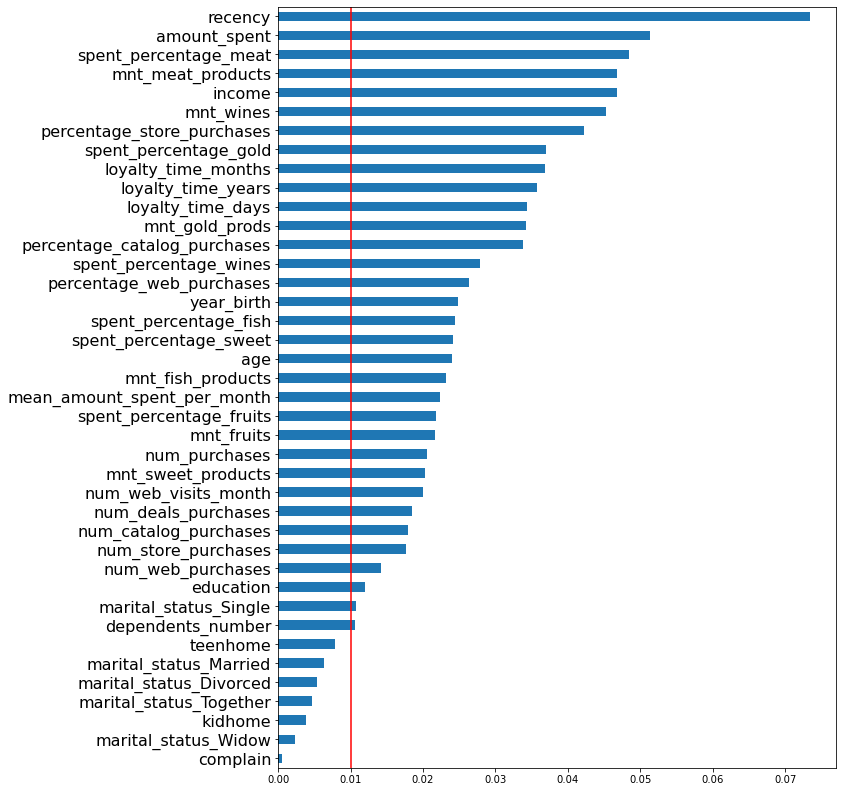

In [21]:
feature_importances = pd.Series( random_forest.feature_importances_, index = X_test.columns ).sort_values()

plt.figure(figsize=(10, 14))
feature_importances.plot(kind='barh');
plt.axvline(0.01, color='r');
plt.yticks(fontsize=16);

In [22]:
selected_columns = feature_importances[feature_importances > 0.01].index

## 2.0 Machine Learning Modelling

                                            Average precision
                                    
                                         Then            Now
        
        RandomForestClassifier       0.61 +- 0.11    0.50 +- 0.13 
        LogisticRegression           0.55 +- 0.05    0.58 +- 0.12
        GradientBoostingClassifier   0.60 +- 0.14    0.57 +- 0.09     
        

In [23]:
new_X = X[selected_columns]
new_X_train = X_train[selected_columns]
new_X_test = X_test[selected_columns]
new_X_test.shape

(617, 33)

In [25]:
predictions = train_test_model(random_forest, new_X_train, new_X_test, y_train, y_test)
cross_validation(random_forest, new_X, y, cv=10, evaluation='precision') 

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       518
           1       0.56      0.20      0.30        99

    accuracy                           0.85       617
   macro avg       0.71      0.59      0.60       617
weighted avg       0.81      0.85      0.81       617

Average precision: 0.5 +- 0.13


In [26]:
predictions = train_test_model(logistic, new_X_train, new_X_test, y_train, y_test)
cross_validation(logistic, new_X, y, cv=10, evaluation='precision') 

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       518
           1       0.59      0.23      0.33        99

    accuracy                           0.85       617
   macro avg       0.73      0.60      0.62       617
weighted avg       0.82      0.85      0.82       617

Average precision: 0.58 +- 0.12


In [27]:
predictions = train_test_model(gradient_boosting, new_X_train, new_X_test, y_train, y_test)
cross_validation(gradient_boosting, new_X, y, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       518
           1       0.66      0.33      0.44        99

    accuracy                           0.87       617
   macro avg       0.77      0.65      0.68       617
weighted avg       0.85      0.87      0.85       617

Average precision: 0.57 +- 0.09


### 2.1 Manual Feature Selection

**Precision when dropping**

    ['amount_spent','loyalty_time_years'] 
    
    .54 +- 0.14    .61 +- 0.11    .60 +- 0.11


    ['spent_percentage_wines', 'spent_percentage_fruits', 'spent_percentage_meat', 'spent_percentage_fish', 
     'spent_percentage_sweet', 'spent_percentage_gold', 'percentage_web_purchases']
    
    .54 +- 0.14    .58 +- 0.13    .61 +- 0.10
     
     
    ['mnt_wines', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods']
     
    .52 +- 0.12    .63 +- 0.14    .57 +- 0.11
    
    
    ['num_deals_purchases', 'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month']
     
    .53 +- 0.12    .62 +- 0.12    .57 +- 0.10

In [28]:
to_drop = ['amount_spent','loyalty_time_years'] 

x_train = X_train.drop(columns=to_drop)
x_test = X_test.drop(columns=to_drop)
xx = X.drop(columns=to_drop)

In [29]:
predictions = train_test_model(random_forest, x_train, x_test, y_train, y_test)
cross_validation(random_forest, xx, y, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       518
           1       0.62      0.16      0.26        99

    accuracy                           0.85       617
   macro avg       0.74      0.57      0.59       617
weighted avg       0.82      0.85      0.81       617

Average precision: 0.54 +- 0.14


In [54]:
predictions = train_test_model(logistic, x_train, x_test, y_train, y_test)
cross_validation(logistic, xx, y, cv=10, evaluation='precision') 

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       518
           1       0.70      0.31      0.43        99

    accuracy                           0.87       617
   macro avg       0.79      0.64      0.68       617
weighted avg       0.85      0.87      0.85       617

Average precision: 0.61 +- 0.11


In [30]:
predictions = train_test_model(gradient_boosting, x_train, x_test, y_train, y_test)
cross_validation(gradient_boosting, xx, y, cv=10, evaluation='precision') 

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       518
           1       0.72      0.34      0.47        99

    accuracy                           0.87       617
   macro avg       0.80      0.66      0.70       617
weighted avg       0.86      0.87      0.85       617

Average precision: 0.6 +- 0.11


### 2.2 Boruta Feature Selection
       
                                            Average precision
                                    
                                        Testing        Feature        Boruta
                                                     Importances
        
        RandomForestClassifier       0.61 +- 0.11    0.50 +- 0.13   0.44 +- 0.16
        LogisticRegression           0.55 +- 0.05    0.58 +- 0.12   0.64 +- 0.16
        GradientBoostingClassifier   0.60 +- 0.14    0.57 +- 0.09   0.55 +- 0.15

In [31]:
cols_selected_boruta = None
# X_train_n, y_train_n = X_train.to_numpy(), y_train.to_numpy()

# %time boruta = BorutaPy(  model, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

['recency', 'mnt_wines', 'mnt_meat_products', 'spent_percentage_meat', 'spent_percentage_gold', 'percentage_store_purchases']

In [273]:
# columns_selected = boruta.support_#.tolist()

# cols_selected_boruta = X_train.iloc[:, columns_selected].columns.to_list()
# cols_selected_boruta

['recency',
 'mnt_wines',
 'mnt_meat_products',
 'spent_percentage_meat',
 'spent_percentage_gold',
 'percentage_store_purchases']

In [95]:
if cols_selected_boruta is None:
    cols_selected_boruta = ['recency', 'mnt_wines', 'mnt_meat_products', 'spent_percentage_meat', 'spent_percentage_gold',
                            'percentage_store_purchases']
cols_selected_boruta

['recency',
 'mnt_wines',
 'mnt_meat_products',
 'spent_percentage_meat',
 'spent_percentage_gold',
 'percentage_store_purchases']

All Features Run:

**cols_selected_boruta = ['recency', 'mnt_wines', 'mnt_meat_products', 'loyalty_time_days', 'num_accepted_cmps',
                        'loyalty_time_years', 'loyalty_time_months', 'spent_percentage_meat', 'spent_percentage_gold',
                        'percentage_store_purchases']**

In [52]:
boruta_X_train = X_train[cols_selected_boruta]
boruta_X_test = X_test[cols_selected_boruta]
boruta_X = X[cols_selected_boruta]

In [36]:
random_forest.fit(boruta_X_train, y_train)

predictions = train_test_model(random_forest, boruta_X_train, boruta_X_test, y_train, y_test)
cross_validation(random_forest, boruta_X, y, cv=10, evaluation='precision') 

              precision    recall  f1-score   support

           0       0.87      0.97      0.91       518
           1       0.55      0.22      0.32        99

    accuracy                           0.85       617
   macro avg       0.71      0.59      0.61       617
weighted avg       0.82      0.85      0.82       617

Average precision: 0.44 +- 0.16


In [37]:
logistic.fit(boruta_X_train, y_train)

predictions = train_test_model(logistic, boruta_X_train, boruta_X_test, y_train, y_test)
cross_validation(logistic, boruta_X, y, cv=10, evaluation='precision') 

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       518
           1       0.62      0.10      0.17        99

    accuracy                           0.85       617
   macro avg       0.74      0.54      0.54       617
weighted avg       0.82      0.85      0.80       617

Average precision: 0.64 +- 0.16


In [38]:
gradient_boosting.fit(boruta_X_train, y_train)

predictions = train_test_model(gradient_boosting, boruta_X_train, boruta_X_test, y_train, y_test)
cross_validation(gradient_boosting, boruta_X, y, cv=10, evaluation='precision') 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       518
           1       0.52      0.24      0.33        99

    accuracy                           0.84       617
   macro avg       0.70      0.60      0.62       617
weighted avg       0.81      0.84      0.82       617

Average precision: 0.55 +- 0.15


## 3.0 Hyperparameter Fine Tuning

### 3.1 Random Forest
    
    {'n_estimators': 800,
     'min_samples_split': 2,
     'min_samples_leaf': 2,
     'max_features': 'auto',
     'max_depth': 100,
     'bootstrap': True}

In [115]:
# parameters = {'bootstrap': [True, False],
#               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#               'max_features': ['auto', 'sqrt'],
#               'min_samples_leaf': [1, 2, 4],
#               'min_samples_split': [2, 5, 10],
#               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# clf = RandomizedSearchCV(random_forest, parameters, scoring="precision", random_state=0)
# search = clf.fit(boruta_X, y)
# search.best_params_

### 3.2 Logistic Regression

    {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}

In [116]:
# parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
#               'penalty': ['none', 'l1', 'l2', 'elasticnet'] ,
#               'C': np.logspace(-3,3,7)} 

# clf = RandomizedSearchCV(logistic, parameters, scoring="precision", random_state=0)
# search = clf.fit(boruta_X, y)
# search.best_params_

### 3.3 Gradient Boosting

    {'n_estimators': 400,
     'min_samples_split': 5,
     'min_samples_leaf': 2,
     'max_features': 'auto',
     'max_depth': 90,
     'learning_rate': 0.15}

In [117]:
# parameters = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#               'max_features': ['auto', 'sqrt'],
#               'min_samples_leaf': [1, 2, 4],
#               'min_samples_split': [2, 5, 10],
#               'n_estimators': [400, 600, 800, 1000, 1200, 1400]}       

# clf = RandomizedSearchCV(gradient_boosting, parameters, scoring="precision", random_state=0)
# search = clf.fit(boruta_X, y)
# search.best_params_

In [40]:
# allDone()

#### GridSearchCV

I would give it a try with gradient_boost, since it showed the best result. But GridSearchCV is taking forever to finish... 

    more than 12 hours asdadasdasd

(-.-)

In [ ]:
# clf = GridSearchCV(gradient_boosting, parameters, scoring="precision")
# search = clf.fit(boruta_X, y)
# search.best_params_
# allDone()

## 4.0 Final Comparisons     
        
                                                    Average precision
                                    
                                        Testing         Feature        Boruta      Boruta+Tuning
                                                      Importances
        
        RandomForestClassifier       0.61 +- 0.11    0.50 +- 0.13   .44 +- 0.16    0.51 +- 0.14
        LogisticRegression           0.55 +- 0.05    0.58 +- 0.12   .64 +- 0.16    0.64 +- 0.16
        GradientBoostingClassifier   0.60 +- 0.14    0.57 +- 0.09   .55 +- 0.15    0.45 +- 0.15

In [57]:
random_forest = RandomForestClassifier(n_estimators=800, min_samples_split=2, min_samples_leaf=2, 
                                       max_features='auto', max_depth=100, bootstrap=True)

predictions = train_test_model(random_forest, boruta_X_train, boruta_X_test, y_train, y_test)
cross_validation(random_forest, boruta_X, y, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       105
           1       0.69      0.80      0.74        83

    accuracy                           0.75       188
   macro avg       0.75      0.75      0.75       188
weighted avg       0.76      0.75      0.75       188

Average precision: 0.5 +- 0.13


In [56]:
logistic = LogisticRegression(solver='lbfgs', penalty='l2', C=1.0)

predictions = train_test_model(logistic, boruta_X_train, boruta_X_test, y_train, y_test)
cross_validation(logistic, boruta_X, y, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.76      0.62      0.68       105
           1       0.61      0.76      0.68        83

    accuracy                           0.68       188
   macro avg       0.69      0.69      0.68       188
weighted avg       0.70      0.68      0.68       188

Average precision: 0.64 +- 0.16


In [44]:
gradient_boosting = GradientBoostingClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features='auto',
                                   max_depth=90, learning_rate=0.15)

predictions = train_test_model(gradient_boosting, boruta_X_train, boruta_X_test, y_train, y_test)
cross_validation(gradient_boosting, boruta_X, y, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       518
           1       0.51      0.23      0.32        99

    accuracy                           0.84       617
   macro avg       0.69      0.59      0.61       617
weighted avg       0.81      0.84      0.82       617

Average precision: 0.45 +- 0.15


## 4.1 Dealing with Imbalance in Data
    
                         Random Forest   Logistic Regression
        Boruta Features:  0.74 +- 0.07      0.71 +- 0.07
           All Features:  0.78 +- 0.05      0.82 +- 0.07

In [58]:
X.shape, boruta_X.shape 

((2056, 40), (2056, 6))

**Boruta Features**

In [59]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(boruta_X, y)
print('Resampled dataset shape %s' % Counter(y_under))

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)

Resampled dataset shape Counter({0: 312, 1: 312})


In [104]:
predictions = train_test_model(random_forest, X_train, X_test, y_train, y_test)
cross_validation(random_forest, X_under, y_under, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       105
           1       0.65      0.82      0.73        83

    accuracy                           0.73       188
   macro avg       0.74      0.74      0.73       188
weighted avg       0.75      0.73      0.73       188

Average precision: 0.74 +- 0.07


In [103]:
predictions = train_test_model(logistic, X_train, X_test, y_train, y_test)
cross_validation(logistic, X_under, y_under, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.79      0.67      0.72       105
           1       0.65      0.77      0.70        83

    accuracy                           0.71       188
   macro avg       0.72      0.72      0.71       188
weighted avg       0.72      0.71      0.71       188

Average precision: 0.71 +- 0.07


In [105]:
# dump(random_forest, 'models/random_forest.joblib') 
# dump(logistic, 'models/logistic_regression.joblib') 

['models/logistic_regression.joblib']

**All Features**

In [106]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_under))

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)

Resampled dataset shape Counter({0: 312, 1: 312})


In [111]:
predictions = train_test_model(random_forest, X_train, X_test, y_train, y_test)
cross_validation(random_forest, X_under, y_under, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.88      0.72      0.80       105
           1       0.72      0.88      0.79        83

    accuracy                           0.79       188
   macro avg       0.80      0.80      0.79       188
weighted avg       0.81      0.79      0.79       188

Average precision: 0.78 +- 0.05


In [113]:
predictions = train_test_model(logistic, X_train, X_test, y_train, y_test)
cross_validation(logistic, X_under, y_under, cv=10, evaluation='precision')

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       105
           1       0.81      0.84      0.83        83

    accuracy                           0.85       188
   macro avg       0.84      0.85      0.84       188
weighted avg       0.85      0.85      0.85       188

Average precision: 0.82 +- 0.07


## 5.0 Business Impact

**Estimated Revenue for Next Campaign.**

> Worst Scenario: R\\$ 15,675.73 <br>
> **Expected:       R\\$ 17,390.27** <br>
> Best Scenario:  R\\$ 19,104.80 <br>



> _"The total cost of the sample campaign was 6.720MU and the revenue generated_
>
> _by the customers who accepted the offer was 3.674MU. Globally the campaign_
>
> _had a profit of -3.046MU. The success rate of the campaign was 15%."_

In [1]:
worst_detection_rate    = .64
expected_detection_rate = .71
best_detection_rate     = .78

campaign_cost    = 6720
customers        = 2240
campaign_revenue = 3674
success_rate     = .15
revenue_per_customer = campaign_revenue/(customers*success_rate)
acquisition_cost = campaign_cost/customers

In [5]:
def estimate_revenue(customers_quantity, target_detection_rate, revenue_per_customer):
    return (customers_quantity * target_detection_rate) * revenue_per_customer

print("Estimated Revenue for Next Campaign Scenarios.\n(Logistic Regression)")
print(f"Worst:    R$ {round( estimate_revenue(customers, worst_detection_rate,    revenue_per_customer), 2)}")
print(f"Expected: R$ {round( estimate_revenue(customers, expected_detection_rate, revenue_per_customer), 2)}")
print(f"Best:     R$ {round( estimate_revenue(customers, best_detection_rate,     revenue_per_customer), 2)}")
print()
print("Estimated Revenue for Next Campaign Scenarios.\n(Random Forest)")
print(f"Worst:    R$ {round( estimate_revenue(customers, .67,    revenue_per_customer), 2)}")
print(f"Expected: R$ {round( estimate_revenue(customers, .74,    revenue_per_customer), 2)}")
print(f"Best:     R$ {round( estimate_revenue(customers, .81,    revenue_per_customer), 2)}")

Estimated Revenue for Next Campaign Scenarios.
(Logistic Regression)
Worst:    R$ 15675.73
Expected: R$ 17390.27
Best:     R$ 19104.8

Estimated Revenue for Next Campaign Scenarios.
(Random Forest)
Worst:    R$ 16410.53
Expected: R$ 18125.07
Best:     R$ 19839.6


In [13]:
profit = revenue_per_customer - acquisition_cost

print("Estimated Profit for Next Campaign Scenarios.\n(Logistic Regression)")
print(f"Worst:    R$ {round( estimate_revenue(customers, worst_detection_rate,    profit), 2)}")
print(f"Expected: R$ {round( estimate_revenue(customers, expected_detection_rate, profit), 2)}")
print(f"Best:     R$ {round( estimate_revenue(customers, best_detection_rate,     profit), 2)}")
print()
print("Estimated Profit for Next Campaign Scenarios.\n(Random Forest)")
print(f"Worst:    R$ {round( estimate_revenue(customers, .67,    profit), 2)}")
print(f"Expected: R$ {round( estimate_revenue(customers, .74,    profit), 2)}")
print(f"Best:     R$ {round( estimate_revenue(customers, .81,    profit), 2)}")

Estimated Profit for Next Campaign Scenarios.
(Logistic Regression)
Worst:    R$ 11374.93
Expected: R$ 12619.07
Best:     R$ 13863.2

Estimated Profit for Next Campaign Scenarios.
(Random Forest)
Worst:    R$ 11908.13
Expected: R$ 13152.27
Best:     R$ 14396.4


In [1]:
revenue_then = 3674
investment_cost = 6720
revenue_now = 17390.27
roi_then = (revenue_then - investment_cost) /investment_cost * 100
roi_now  = (revenue_now - investment_cost) /investment_cost * 100
print(f"Current ROI:   {roi_then}")
print(f"Estimated ROI: {roi_now} ")

Current ROI:   -45.32738095238095
Estimated ROI: 158.78377976190475 


## Notes

- Model features

recency	mnt_wines	mnt_meat_products	spent_percentage_meat	spent_percentage_gold	percentage_store_purchases


- Model Chosen

Random Forest is slightly better than Logistic Regression, but it also is way heavier.<br>
For this context, it would be a good idea to use it, but it may not be as the data and complexity of the model increase.<br>
Since logistic regression showed us positive results as well, it could save us money on the cloud computing service cost without big performance losses. 

### <font color='grey'>Test</font>
<font color='grey'>Trying to locate targets without machine learning. But with quantiles most probable to encounter the targets.</font>

In [3]:
frames = []
data_frame = raw_data.copy()
for c in data_frame.select_dtypes( include=['int64', 'float64'] ).columns:
    quant = np.arange(0, 1, 0.1)          # Create a quantile array [.0 to .9]
    quant.put(len(quant) - 1, 1)          # Replace quantile .9 -> 1
    bins=np.nanquantile(data_frame[c], quant)   # Compute the quantile of the value
    bins=np.unique(bins)                                 # Get the unique values 
    data_frame[f"{c}_cat"] = pd.cut(data_frame[c], bins) # to create groups according to that column distribution
    
    # What percentage of customers accepted the campaign in that group?
    frames.append( data_frame.groupby(f"{c}_cat")['response'].agg(['mean','count']) )
frames[1]

,mean,count
income_cat,,
"(7464.0, 24307.5]",0.123077,195
"(24307.5, 32313.0]",0.101942,206
"(32313.0, 38552.0]",0.136585,205
"(38552.0, 45143.0]",0.106796,206
"(45143.0, 52095.5]",0.107317,205
"(52095.5, 58113.0]",0.111650,206
"(58113.0, 65052.0]",0.117073,205
"(65052.0, 71691.0]",0.116505,206
"(71691.0, 666666.0]",0.301703,411


In [5]:
frames[0]

In [7]:
targets = raw_data[(raw_data['income'] > 71000) & (raw_data['recency'] < 40) &
                   (raw_data['loyalty_time_days'] > 420) & (raw_data['mean_amount_spent_per_month'] > 49)] 

print('Percent:  ', round( targets.response.sum()/targets.shape[0] * 100, 2), '%' )
print('Targets:  ', targets.response.sum())
print('Total:    ', targets.shape[0])

Percent:   50.85 %
Targets:   30
Total:     59


- income_cat > 71mil

- recency_cat < 40

mnt_wine_cat > 420

mnt_fruits_cat> 15

mnt_meat_products_cat > 290

mnt_fish_products_cat > 20

mnt_sweet_products_cat > 14

mnt_gold_prods_cat > 16

num_catalog_purchases_cat > 2

num_store_purchases_cat > 4

num_purchases_cat > 12

amount_spent_cat > 1000

- loyalty_time_days_cat > 420

loyalty_time_months_cat > 14

- mean_amount_spent_per_month_cat > 49

- age_cat < 36

spent_percentage_wines_cat < 0.75

spent_percentage_meat_cat > 0.35

spent_percentage_fish_cat < 0.14

spent_percentage_sweet_cat < 0.1

percentage_web_purchases_cat > 0.3

percentage_catalog_purchases_cat > 0.15

percentage_store_purchases_cat < 0.4